# Trabajo Practico N°1 | Modelo predictivo de tarifas de Uber

## Introducción
Para este primer trabajo práctico de la materia realizamos en base a un dataset proporcionado, el cual detalla tarifas del servicio de transporte Uber, un modelo de predicción de tarifas. Para el cual previamente debimos realizar toda una serie de pasos para llegar hasta la culminación de dicho instrumento, aquellos pasos serán explicados en este archivo para poder comprender la naturaleza y complejidad del proyecto realizado.



### Importación de librerías
Comenzamos con la importación de todas las librerías que nos serán imprescindibles para poder cargar, visualizar, manipular, transformar y predecir, entre otras acciones importantes, nuestros datos.


In [269]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("bright")

import holidays
from haversine import haversine, Unit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

### Carga del dataset

In [270]:
#Ruta al csv
file_path= 'uber_fares.csv'

#Lectura del csv
df = pd.read_csv(file_path)

#Observamos primeras lineas
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Primer vistazo

In [271]:
#Informacion general sobre las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [272]:
#Comportamiento de variables numericas
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [273]:
#Valores nulos
df.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

## Análisis Descriptivo
Al realizar la primera lectura del dataset observamos que nos encontramos con un documento con 200000 registros correspondientes a viajes en uber de la zona de la ciudad de Nueva York, el cual se presenta con las columnas:


**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  


**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  


Contamos con únicamente 2 valores nulos en las variables "dropoff_longitude" y "dropoff_latitude", las columnas numéricas presentan información acerca de las coordenadas de inicio y fin del viaje, las cuales en su primer vistazo comprobamos que poseen valores fuera del rango utilizado para ellas (-90 a 90 para latitud, -180 a 180 para longitud) por lo que tendremos que tomar una decisión sobre cómo tratarlas.
La variable "passenger_count" que detalla cuántas personas se suben al viaje contratado, valor el cual ingresa manualmente el chofer del servicio, varía entre 0 a 6 personas con una excepción de un valor erróneo de 208, el cual para el trabajo que estamos realizando es imposible.
Además podemos observar cómo se comporta nuestra variable objetivo en este proyecto la cual es "fare_amount", la cual detalla el valor en dólares que se le asigna a dicho viaje, y es ahí donde podemos observar valores negativos, los cuales no serán tenidos en cuenta en nuestro desarrollo porque no podremos saber nunca su precio real, así como un valor sorprendentemente alto pero no imposible de 499 dólares, el cual deberemos analizar más adelante junto con el resto de las tarifas.


A continuación realizamos algunos gráficos que nos dará un pantallazo inicial de cómo se comportan las variables mencionadas anteriormente.







Text(0.5, 1.0, 'Boxplot precios')

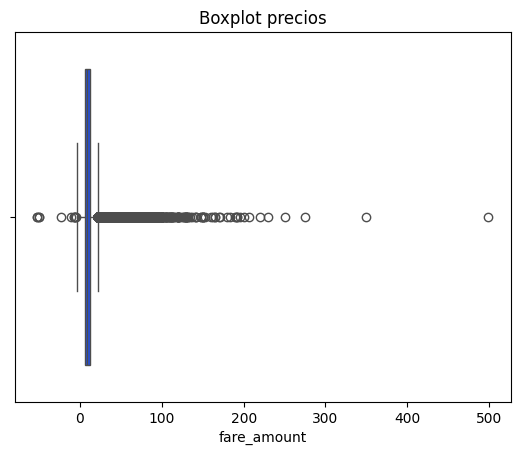

In [274]:
#Distribucion del precio
sns.boxplot(df,x='fare_amount')
plt.title("Boxplot precios")

Text(0.5, 1.0, 'Recuento de pasajeros por viaje')

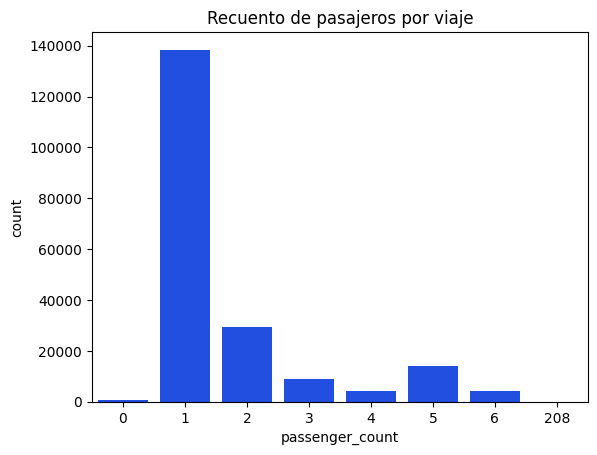

In [275]:
#Grafico recuento de pasajeros
sns.countplot(df,x='passenger_count')
plt.title("Recuento de pasajeros por viaje")

(-90.0, 90.0)

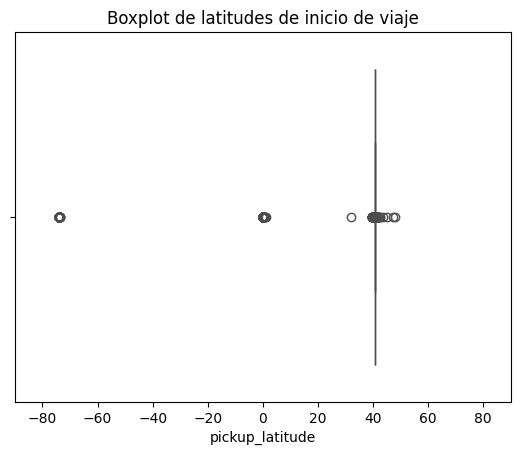

In [276]:
#Visualizacion de latitud de inicio
sns.boxplot(df,x='pickup_latitude')
plt.title('Boxplot de latitudes de inicio de viaje')
plt.xlim(-90,90)

Text(0.5, 1.0, 'Boxplot de longitudes de finalizacion de viaje')

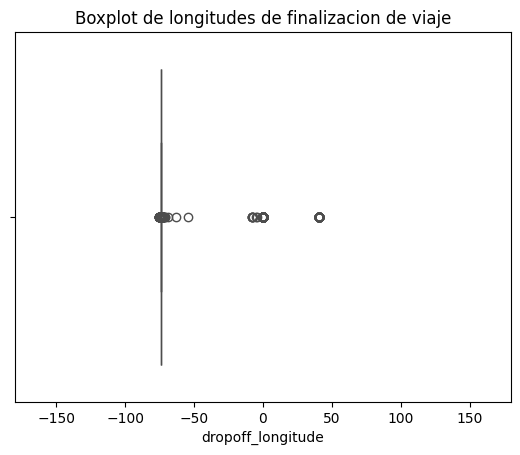

In [277]:
#Visualizacion de longitud de finalizacion
sns.boxplot(df,x='dropoff_longitude')
plt.xlim(-180,180)
plt.title('Boxplot de longitudes de finalizacion de viaje')

Text(0.5, 1.0, 'Distribucion de las tarifas')

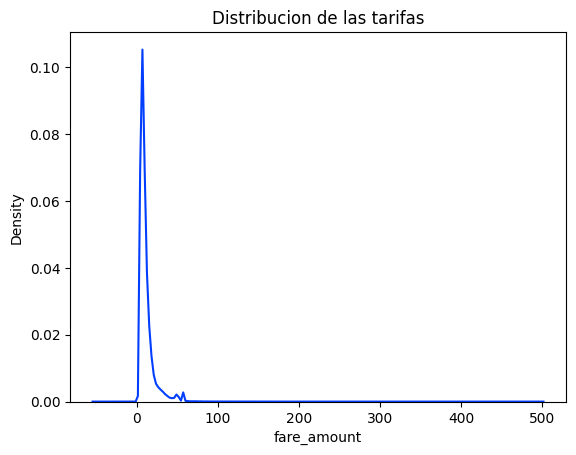

In [278]:
sns.kdeplot(df,x='fare_amount')
plt.title("Distribucion de las tarifas")

Como podemos observar, las columnas que detallan la ubicación al graficarlas nos dan una representación visual de los valores atípicos presentes en ellas, asimismo la variable precio pareciera que posee también una gran cantidad de outliers pero para confirmarlo debemos realizar un análisis más profundo de dicha característica.

## Limpieza y primeras modificaciones
Para comenzar con nuestra intervención al dataset lo primero que haremos será eliminar dos de las columnas que no nos serán de utilidad, la primera de ellas es "key" la cual no es más que un identificador y para el trabajo que estamos realizando no nos interesa estudiar casos particulares (en caso de necesitarlo contamos con el índice de pandas) y por otro lado la columna "date" tampoco la tendremos en cuenta ya que la información que presenta es la misma que la de la columna "pickup_datetime", por lo que nos quedaremos con esta última.

In [279]:
df.drop(columns=["key","date"],inplace=True)

### Corrección de errores
Luego de la eliminación de las dos columnas, nos centramos en los valores que presentan características erróneas para su corrección, es por eso que optamos por corregir las columnas que detallan las coordenadas de inicio y finalización de viaje las cuales presentan valores fuera de escala. Luego de una primera inspección observamos que hay valores que si les corregimos su posición decimal podrían ser valores que se encuentran en el rango de observaciones del dataset, el cual ronda el 40 para las latitudes y -70 para longitudes, por lo que dividimos por 10 aquellos valores para corregirlos. Aún luego de esta manipulación hay valores que siguen estando fuera del rango por lo que estos serán eliminados. Adicionalmente transformamos el tipo de dato de la columna "pickup_datetime" a formato datetime.

In [280]:
# Obtenemos los registros que tienen longitudes o latitudes fuera de los rangos posibles (+-180 para longitudes y +-90 para latitudes)
df_filtrado = df[(df["pickup_latitude"] < -90) | (df["pickup_latitude"] > 90) | (df["dropoff_latitude"] < -90) | (df["dropoff_latitude"] > 90) | 
                 (df["pickup_longitude"] < -180) | (df["pickup_longitude"] > 180) | (df["dropoff_longitude"] < -180) | (df["dropoff_longitude"] > 180)]


#Realizamos la division por 10 para corregir errores de coma
df_filtrado["pickup_longitude"] = df_filtrado["pickup_longitude"].apply(lambda x: x/10 if abs(x) > 180 else x)
df_filtrado["pickup_latitude"] = df_filtrado["pickup_latitude"].apply(lambda x: x/10 if abs(x) > 90 else x)
df_filtrado["dropoff_longitude"] = df_filtrado["dropoff_longitude"].apply(lambda x: x/10 if abs(x) > 180 else x)
df_filtrado["dropoff_latitude"] = df_filtrado["dropoff_latitude"].apply(lambda x: x/10 if abs(x) > 90 else x)

#Actualiza el df original con los nuevos valores
df.update(df_filtrado)

#Eliminacion de coordenadas erroneas
df = df.drop(index= [75851,91422])

# Convertir columna "pickup_datetime" de tipo string a tipo datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


### Valores atípicos
En la siguiente instancia nos detuvimos a observar comportamientos fuera de lo común de algunas variables, para ello tuvimos que tomar algunas decisiones. La variable que detalla cuántos pasajeros hubo en el viaje, el cual es un número ingresado a mano por el conductor, presenta valores del 0 al 6 pero con una excepción de un número mucho más grande el cual será modificado manualmente por el mayor de los valores presentes en el rango nombrado anteriormente. A su vez la variable target en este caso, ‘fare_amount’, que indica cuanto salió el viaje también presenta valores que no nos son útiles para el trabajo que estamos desarrollando, por eso se eliminaron todos los registros donde la variable valía menos que 1, lo cual es un valor que indicamos nosotros y establecimos como el mínimo a tener en cuenta, por lo que valores nulos y negativos fueron eliminados. Si observamos ahora la distribución de la variable precio, podemos observar que se encuentran la mayor cantidad de los viajes alrededor de los 10 dólares, seguidos de unos leves picos entre los 45 y 60 dólares aproximadamente.


Siguiendo con la variable target, así como recortamos sus valores a mayores a uno, también establecimos un límite superior optando por el quantil del 99.5%, para evitar trabajar con outliers extremos.

In [281]:
# Registros con mas de 6 pasajeros
df_pasajeros_outl= df[(df["passenger_count"] > 6)]

df_pasajeros_outl

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,11.7,2010-12-28 08:20:00+00:00,-73.937795,40.758498,-73.937835,40.758415,208


In [282]:
# Cambiar el unico registro con valor invalido al maximo valor posible
df["passenger_count"] = df["passenger_count"].mask((df["passenger_count"] > 6), 6)

In [283]:
# Registros con precios menores a 1
df_fare_outl= df[(df["fare_amount"] < 1)]
df_fare_outl.shape

(25, 7)

In [284]:
# Eliminar los registros con precios menores a 1
df.drop(index=df_fare_outl.index, inplace=True)

(0.0, 100.0)

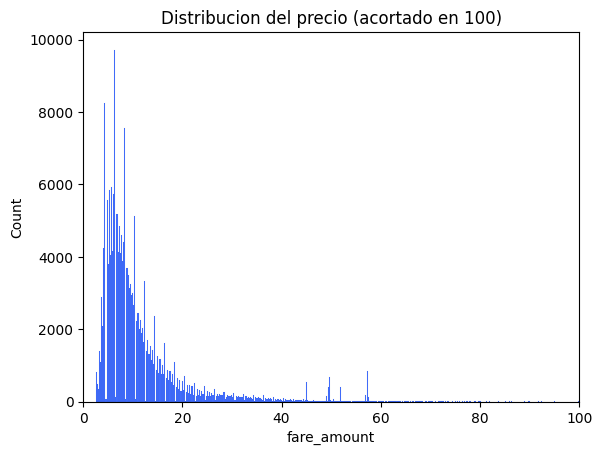

In [285]:
sns.histplot(df,x='fare_amount')
plt.title("Distribucion del precio (acortado en 100)")
plt.xlim(0,100)

### División entrenamiento - testeo
Llegados a este punto realizamos la división de nuestros datos en dos grupos que posteriormente usaremos para las tareas de entrenamiento, ajuste, validación y testeo de nuestro modelo, es importante realizar conscientemente para evitar contaminar los valores del testeo con los de entrenamiento, dando lugar a posibles variaciones no deseadas en las métricas de nuestros datos.

In [286]:
# Division de los datos
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Comprobamos la forma de la division
print(train.shape, test.shape)

(159978, 7) (39995, 7)


In [287]:
# Conservamos el 99,5%
limite_tarifa = train["fare_amount"].quantile(0.995)

# Eliminamos aquellos valores pertenecientes al 0,5% superior de los datos 
train.drop(train[train['fare_amount'] > limite_tarifa].index, inplace=True)
test.drop(test[test['fare_amount'] > limite_tarifa].index, inplace=True)

### Alcance geográfico del modelo
Así como tomamos algunos criterios particulares para manipular algunas variables, también definimos el alcance que iba a tener nuestro modelo. Como el mayor porcentaje de los viajes son dentro de la ciudad de Nueva York, establecimos límites en las coordenadas para delimitar una zona de actuación del modelo, dichas coordenadas son (40 a 42) para latitud y (-75 a -70) para longitud, de esa manera abarcamos el área de la ciudad y sus alrededores.
Teniendo esa delimitación, tuvimos que tomar una decisión con aquellos valores que quedaban fuera del rango que antes delimitamos, es por ello que para esos valores aplicamos la siguiente regla: si las coordenadas se encuentran por encima del límite superior (establecido como el quantil 3 más 1.5 multiplicado por el rango intercuartílico) o por debajo del límite inferior (establecido como el cuantil 1 menos 1.5 multiplicado por el rango intercuartílico), de esa manera transforma aquellos valores que estén fuera de esos sectores como NaN para su posterior imputación, por último nos quedamos con el dataset resultante y lo concatenamos al del área de Nueva York.

In [288]:
# Obtener todos los registros de train y test que por sus coordenas pertenecen aproximadamente al area de la ciudad de Nueva York
train_area_NY = train[
    (train["pickup_latitude"]  > 40) & (train["pickup_latitude"]  < 42) &
    (train["pickup_longitude"] > -75) & (train["pickup_longitude"] < -70) &
    (train["dropoff_latitude"] > 40) & (train["dropoff_latitude"] < 42) &
    (train["dropoff_longitude"] > -75) & (train["dropoff_longitude"] < -70)]

test_area_NY = test[
    (test["pickup_latitude"]  > 40) & (test["pickup_latitude"]  < 42) &
    (test["pickup_longitude"] > -75) & (test["pickup_longitude"] < -70) &
    (test["dropoff_latitude"] > 40) & (test["dropoff_latitude"] < 42) &
    (test["dropoff_longitude"] > -75) & (test["dropoff_longitude"] < -70)]

In [289]:
# Cantidad de registros que NO estan en el area de NY
len(train)-len(train_area_NY),len(test)-len(test_area_NY)

(3294, 845)

In [290]:
# Calcular los limites inferior y superior para detectar outliers sobre el conjunto train
columnas_coor= ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

Q1 = train_area_NY[columnas_coor].quantile(0.25)
Q3 = train_area_NY[columnas_coor].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

In [291]:
# Obtener registros de train y test que NO estan comprendidos en el area de NY

train_No_area_NY = train[
    ~(
    (train["pickup_latitude"]  > 40) & (train["pickup_latitude"]  < 42) &
    (train["pickup_longitude"] > -75) & (train["pickup_longitude"] < -70) &
    (train["dropoff_latitude"] > 40) & (train["dropoff_latitude"] < 42) &
    (train["dropoff_longitude"] > -75) & (train["dropoff_longitude"] < -70)
    )
]

test_No_area_NY = test[
    ~(
    (test["pickup_latitude"]  > 40) & (test["pickup_latitude"]  < 42) &
    (test["pickup_longitude"] > -75) & (test["pickup_longitude"] < -70) &
    (test["dropoff_latitude"] > 40) & (test["dropoff_latitude"] < 42) &
    (test["dropoff_longitude"] > -75) & (test["dropoff_longitude"] < -70)
    )
]

In [292]:
# Reemplazar por NaN los valores en los registros que por sus coordenadas no pertenecen al area de NY con respecto
# a las metricas de los registros que si pertenecen al area de NY

# Para train
for col in columnas_coor:
    mask_outlier = (train_No_area_NY[col] < limite_inferior[col]) | (train_No_area_NY[col] > limite_superior[col])
    train_No_area_NY.loc[mask_outlier, col] = np.nan

# Para test
for col in columnas_coor:
    mask_outlier = (test_No_area_NY[col] < limite_inferior[col]) | (test_No_area_NY[col] > limite_superior[col])
    test_No_area_NY.loc[mask_outlier, col] = np.nan


# Volver a armar los dataset de train y test con los outliers reemplazados por NaN para despues imputarlos
train= pd.concat([train_area_NY, train_No_area_NY]).sort_index()

test= pd.concat([test_area_NY, test_No_area_NY]).sort_index()

### Adición de variables
Para la creación de los futuros modelos predictivos, necesitamos una cantidad de variables que expliquen el comportamiento de la target, es por eso que en esta etapa agregamos ciertas columnas que nos serán útiles para lograr nuestro objetivo. Inicialmente se agregan aquellas referidas a las fechas, las cuales son una descomposición de la variable ‘pickup_datetime’ y resultan en hora, día de la semana, día del mes, mes y año. Posteriormente realizamos algunos gráficos para observar cómo se comportan esas variables según el número de viajes en cada una, dicho análisis nos resultará útil más adelante para no usar todas ellas, en su lugar podremos agruparlas según nos sea más representativo.


Al tratarse de un dataset situado en Nueva York, Estados Unidos, añadimos una columna adicional que nos indica si el día en el que se realizó ese viaje, era feriado en dicho país, creemos que podría indicar una suba del precio del mismo.


Además se agrega una columna importante en este trabajo la cual es la distancia Haversine, la cual expresa la distancia existente entre dos puntos en la superficie de una esfera, en nuestro caso la tierra.

In [293]:
# Calcular distancia del viaje en linea recta 
train["distancia_haversine_km"] = train.apply(

    lambda row: haversine(
        (row["pickup_latitude"], row["pickup_longitude"]),
        (row["dropoff_latitude"], row["dropoff_longitude"]),
        unit=Unit.KILOMETERS
    ),
    axis=1
)


test["distancia_haversine_km"] = test.apply(

    lambda row: haversine(
        (row["pickup_latitude"], row["pickup_longitude"]),
        (row["dropoff_latitude"], row["dropoff_longitude"]),
        unit=Unit.KILOMETERS
    ),
    axis=1
)

In [294]:
# Diccionario de feriados USA
us_holidays = holidays.US()
train['es_feriado'] = train['pickup_datetime'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

# Creacion de columnas a partir de pickup_datetime
train['year'] = train['pickup_datetime'].dt.year
train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['weekday'] = train['pickup_datetime'].dt.weekday
train['hour'] = train['pickup_datetime'].dt.hour



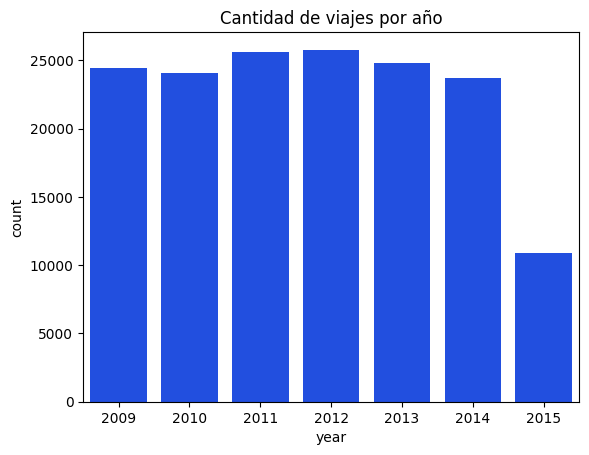

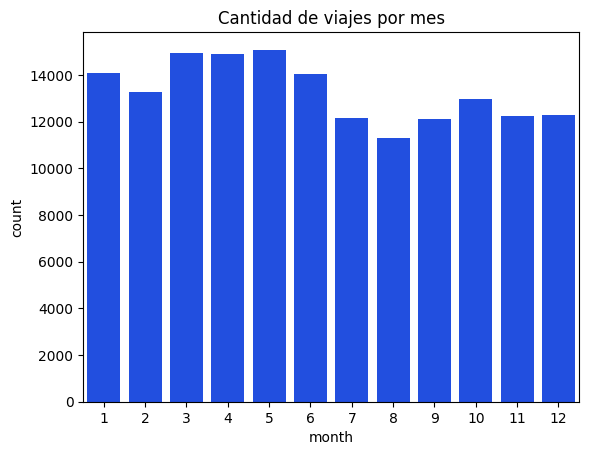

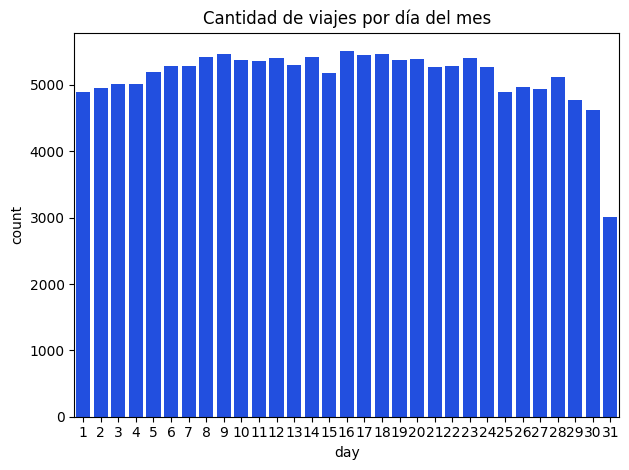

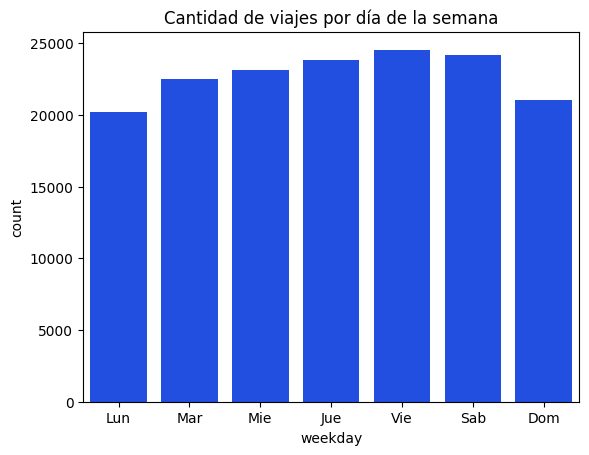

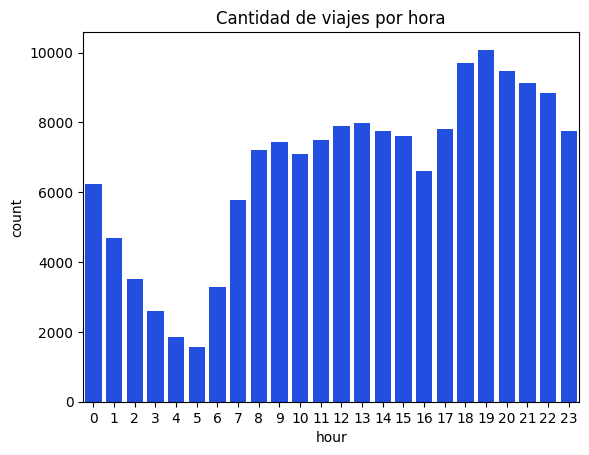

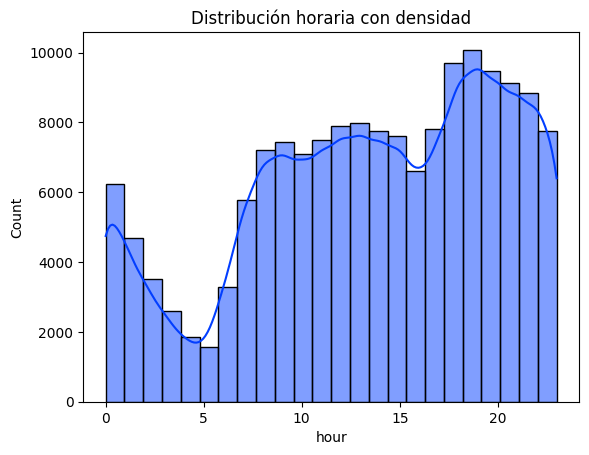

In [295]:
# Graficos para visualizar la segmentacion del tiempo

sns.countplot(train, x='year')
plt.title("Cantidad de viajes por año")
plt.show()

sns.countplot(train, x='month')
plt.title("Cantidad de viajes por mes")
plt.show()


sns.countplot(train, x='day')
plt.title("Cantidad de viajes por día del mes")
plt.tight_layout()
plt.show()


dias = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']
sns.countplot(train, x='weekday')
plt.xticks(ticks=range(7), labels=dias)
plt.title("Cantidad de viajes por día de la semana")
plt.show()


sns.countplot(train, x='hour')
plt.title("Cantidad de viajes por hora")
plt.show()


sns.histplot(train['hour'], bins=24, kde=True)
plt.title("Distribución horaria con densidad")
plt.show()



Observando los gráficos de arriba tomamos los siguientes criterios para representar las fechas en nuestro proyecto:
- Se agruparán los meses en trimestres, ya que se observan en el gráfico como existen diferencias entre la primera y segunda mitad del año y para tener más control sobre esos periodos se los vuelve a dividir en dos grupos más.
- Se agruparán las horas en 4 grupos de 6 horas cada uno, ya que en la gráfica se observan algunos mínimos y máximos locales que nos ayudan a diferenciarlos.
- Los días de la semana se convertirán en dos grupos, Viernes a Domingo para representar el inicio temprano y finalización de los fines de semana y por otro lado de Lunes a Jueves será el grupo restante.
- Para agrupar los días del mes en donde se tomaron los viajes, en lugar de tomar 31 variables, las cuales nos parecen demasiadas para tener en cuenta, los agrupamos en grupos de semanas que varían de la primera a la cuarta.

In [296]:
# Transformaciones para train

train['Trimestre'] = train['month'].map({1:'T1', 2:'T1', 3:'T1',
                                            4:'T2', 5:'T2', 6:'T2',
                                            7:'T3', 8:'T3', 9:'T3',
                                            10:'T4', 11:'T4', 12:'T4'})

train['Segmento_horas'] =  train['hour'].map({0:'H1', 1:'H1', 2:'H1', 3:'H1', 4:'H1', 5:'H1',
                                              6:'H2', 7:'H2', 8:'H2', 9:'H2', 10:'H2', 11:'H2',
                                              12:'H3', 13:'H3', 14:'H3', 15:'H3', 16:'H3', 17:'H3',
                                              18:'H4', 19:'H4', 20:'H4', 21:'H4', 22:'H4', 23:'H4'})

train['Dia_Semana'] =  train['weekday'].map({0:'Lun-Jue', 1:'Lun-Jue', 2:'Lun-Jue', 3:'Lun-Jue',
                                             4:'Vie-Dom', 5:'Vie-Dom', 6:'Vie-Dom'})


train['Tipo_Uber'] = train['passenger_count'].map({0:'Eats',
                                                   1:'Regular', 2:'Regular', 3:'Regular', 4:'Regular',
                                                   5:'UberXL', 6:'UberXL'})

train['semana_1_4'] = np.minimum(((train['day'] - 1) // 7) + 1, 4)



# Transformaciones para test
test['year'] = test['pickup_datetime'].dt.year
test['month'] = test['pickup_datetime'].dt.month
test['day'] = test['pickup_datetime'].dt.day
test['weekday'] = test['pickup_datetime'].dt.weekday
test['hour'] = test['pickup_datetime'].dt.hour
test['es_feriado'] = test['pickup_datetime'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)



test['Trimestre'] = test['month'].map({1:'T1', 2:'T1', 3:'T1',
                                            4:'T2', 5:'T2', 6:'T2',
                                            7:'T3', 8:'T3', 9:'T3',
                                            10:'T4', 11:'T4', 12:'T4'})

test['Segmento_horas'] =  test['hour'].map({0:'H1', 1:'H1', 2:'H1', 3:'H1', 4:'H1', 5:'H1',
                                              6:'H2', 7:'H2', 8:'H2', 9:'H2', 10:'H2', 11:'H2',
                                              12:'H3', 13:'H3', 14:'H3', 15:'H3', 16:'H3', 17:'H3',
                                              18:'H4', 19:'H4', 20:'H4', 21:'H4', 22:'H4', 23:'H4'})

test['Dia_Semana'] =  test['weekday'].map({0:'Lun-Jue', 1:'Lun-Jue', 2:'Lun-Jue', 3:'Lun-Jue',
                                             4:'Vie-Dom', 5:'Vie-Dom', 6:'Vie-Dom'})


test['Tipo_Uber'] = test['passenger_count'].map({0:'Eats',
                                                   1:'Regular', 2:'Regular', 3:'Regular', 4:'Regular',
                                                   5:'UberXL', 6:'UberXL'})

test['semana_1_4'] = np.minimum(((test['day'] - 1) // 7) + 1, 4)

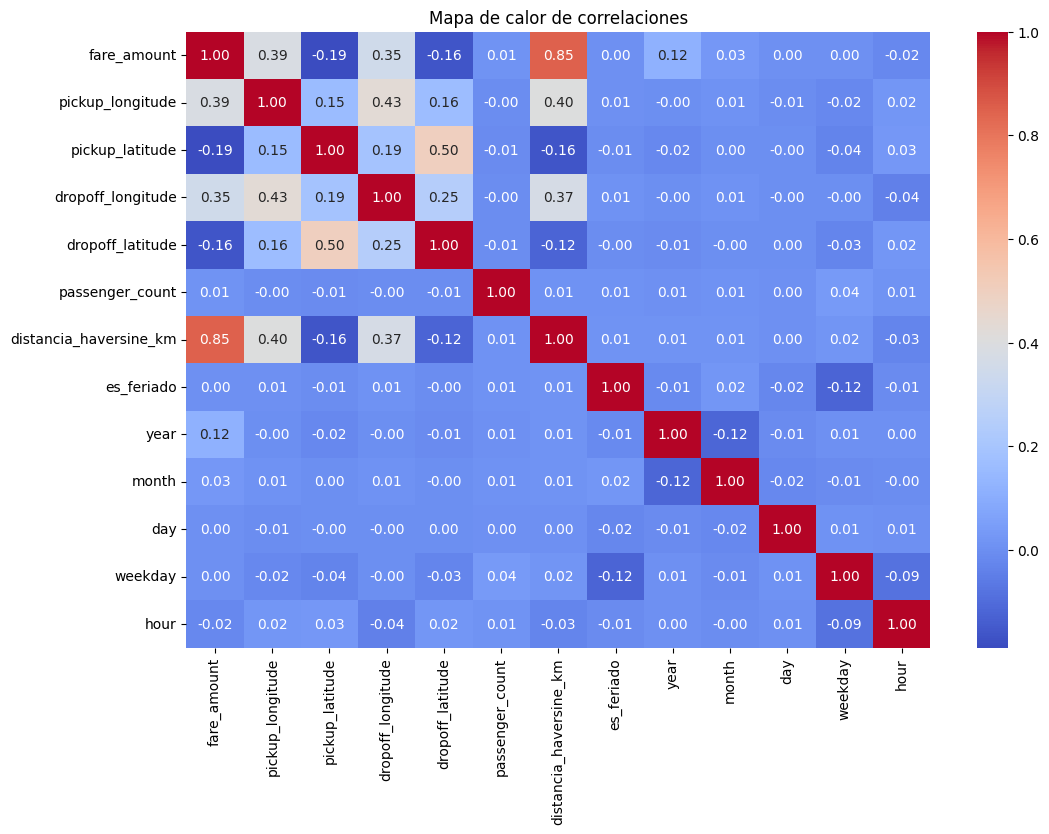

In [297]:
# Grafico heatmap para analizar correlaciones
# Selecciono columnas numericas
train_num = train.select_dtypes(include=["int64", "float64","int32"])
corr = train_num.corr()
# Grafico
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones")
plt.show()


Observamos hasta el momento que existen algunas correlaciones lineales entre nuestras variables, lógicamente la más fuerte es la que relaciona la distancia con el precio, ya que es la que principalmente modela a la target. También observamos relaciones menos fuertes entre las propias coordenadas, y a un nivel inferior con la variable dependiente.

In [298]:
train.columns


Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'distancia_haversine_km', 'es_feriado', 'year', 'month', 'day',
       'weekday', 'hour', 'Trimestre', 'Segmento_horas', 'Dia_Semana',
       'Tipo_Uber', 'semana_1_4'],
      dtype='object')

## Preprocesamiento de los datos
En esta etapa ya tenemos todas las columnas que necesitamos para comenzar con nuestro análisis, pero si las introducimos ahora como están no podrán ser interpretadas por los modelos, ya que los mismos solo entienden de números, vectores y matrices, en cambio nosotros tenemos todavía variables que representan características, agrupaciones. Es por ello que en esta etapa debemos transformar dichas características al lenguaje que entienden los modelos, la herramienta que nos será de utilidad es One Hot Encoder la cual se encargará de esa tarea, convertir los valores no numéricos en un formato de unos y ceros agregando columnas según la cantidad de posibles valores que tenga esa característica.


Seguido a ello, es buena práctica una vez que tenemos las columnas en formato numérico, escalarlas para que todas estén dentro de una escala similar y no sean tan dispares los valores, para ello utilizamos el escalador estándar , el cual transforma los valores para que tengan una media de 0 y un desvío estándar de 1.


Posteriormente como tenemos todavía valores Nan que imputar, lo que decidimos hacer fue rellenarlos utilizando el modelo de K vecinos cercanos (KNN), entrenandolos con un k=4 sobre los datos de train y aplicando sobre ambos conjuntos.

In [299]:
# Separar variable target antes de estandarizar
y_train = train["fare_amount"]
y_test = test["fare_amount"]

In [300]:
# Hacer One Hot Encoding en train

# Columnas categóricas a transformar
columnas_cat = ['passenger_count', 'year', 'Trimestre', 'Segmento_horas', 'Dia_Semana', 'Tipo_Uber', 'semana_1_4']

# Inicializamos el encoder
encoder = OneHotEncoder(sparse_output=False ) #drop='first'

# Ajustamos y transformamos solo las columnas categóricas
encoded_array = encoder.fit_transform(train[columnas_cat])

# Obtenemos los nombres de las nuevas columnas
encoded_cols = encoder.get_feature_names_out(columnas_cat)

# Convertimos el resultado en DataFrame
df_encoded_train = pd.DataFrame(encoded_array, columns=encoded_cols, index=train.index)

# Concatenamos al DataFrame original 
train = pd.concat([train.drop(columns=columnas_cat), df_encoded_train], axis=1)


In [301]:
# Hacer One Hot Encoding en test

# Columnas categóricas a transformar
columnas_cat = ['passenger_count', 'year', 'Trimestre', 'Segmento_horas', 'Dia_Semana', 'Tipo_Uber', 'semana_1_4']

# Inicializamos el encoder
encoder = OneHotEncoder(sparse_output=False)  #drop='first'

# Ajustamos y transformamos solo las columnas categóricas
encoded_array = encoder.fit_transform(test[columnas_cat])

# Obtenemos los nombres de las nuevas columnas
encoded_cols = encoder.get_feature_names_out(columnas_cat)

# Convertimos el resultado en DataFrame
df_encoded_test = pd.DataFrame(encoded_array, columns=encoded_cols, index=test.index)

# Concatenamos al DataFrame original 
test = pd.concat([test.drop(columns=columnas_cat), df_encoded_test], axis=1)


In [302]:
train = train.drop(columns=['pickup_datetime','day','month','weekday','hour','weekday'])

test = test.drop(columns=['pickup_datetime','day','month','weekday','hour','weekday'])


cols_to_scale = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distancia_haversine_km']  

scaler = StandardScaler()

# Ajustamos SOLO con columnas de train
scaler.fit(train[cols_to_scale])

# Escalamos train y test en esas columnas
train_scaled = train.copy()
test_scaled = test.copy()

train_scaled[cols_to_scale] = scaler.transform(train[cols_to_scale])
test_scaled[cols_to_scale] = scaler.transform(test[cols_to_scale])

In [303]:
train_scaled.isna().sum()

fare_amount                  0
pickup_longitude          3132
pickup_latitude           3122
dropoff_longitude         3114
dropoff_latitude          3115
distancia_haversine_km    3294
es_feriado                   0
passenger_count_0            0
passenger_count_1            0
passenger_count_2            0
passenger_count_3            0
passenger_count_4            0
passenger_count_5            0
passenger_count_6            0
year_2009                    0
year_2010                    0
year_2011                    0
year_2012                    0
year_2013                    0
year_2014                    0
year_2015                    0
Trimestre_T1                 0
Trimestre_T2                 0
Trimestre_T3                 0
Trimestre_T4                 0
Segmento_horas_H1            0
Segmento_horas_H2            0
Segmento_horas_H3            0
Segmento_horas_H4            0
Dia_Semana_Lun-Jue           0
Dia_Semana_Vie-Dom           0
Tipo_Uber_Eats               0
Tipo_Ube

In [304]:
# Se imputan valores faltantes con KNN
imputer = KNNImputer(n_neighbors=4)
imputer.fit(train_scaled) 

train_imputed = pd.DataFrame(imputer.transform(train_scaled), columns=train_scaled.columns, index=train_scaled.index) 
test_imputed = pd.DataFrame(imputer.transform(test_scaled), columns=test_scaled.columns, index=test_scaled.index)

In [305]:
# Guardamos tambien las variables y estandarizadas
y_train_std = train_scaled["fare_amount"]
y_test_std = test_scaled["fare_amount"]

In [306]:
# Eliminar target de las features
X_train_std = train_imputed .drop(columns=["fare_amount"])
X_test_std = test_imputed.drop(columns=["fare_amount"])

In [307]:
X_train_std

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distancia_haversine_km,es_feriado,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,...,Segmento_horas_H4,Dia_Semana_Lun-Jue,Dia_Semana_Vie-Dom,Tipo_Uber_Eats,Tipo_Uber_Regular,Tipo_Uber_UberXL,semana_1_4_1,semana_1_4_2,semana_1_4_3,semana_1_4_4
0,-0.633899,-0.425050,-0.677817,-0.849446,-0.439199,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.492343,-0.763562,-0.549899,-0.030440,-0.226630,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.769345,-0.344296,0.306444,0.643968,0.481356,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.019849,1.329227,0.233157,1.571558,-0.445140,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,0.164292,0.161698,0.134509,0.138298,-0.901343,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199994,-0.199869,0.324124,0.029201,0.085939,-0.593065,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
199995,-0.302811,-0.391186,-0.331851,-0.333413,-0.870536,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
199996,-0.242684,-0.475741,-0.868567,-0.353867,-0.386562,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
199997,-0.276246,0.180982,3.066563,-1.774831,2.626615,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Entrenamiento de modelos
Llegados a este punto ya tenemos todo para comenzar con el entrenamiento de nuestros modelos, ajustando parámetros, probando diferentes variaciones y comparando métricas con el fin de llegar al mejor punto posible.

### Regresion Lineal

          Train       Test
MSE   19.236158  18.888021
RMSE   4.385905   4.346035
R²     0.751885   0.752366
MAPE   0.234317   0.232665
Tiempo: 0.22


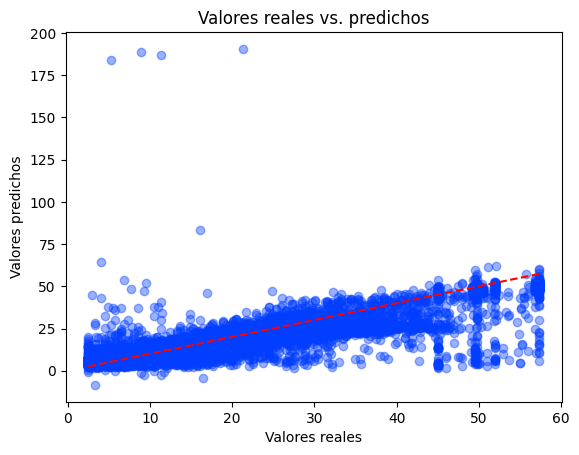

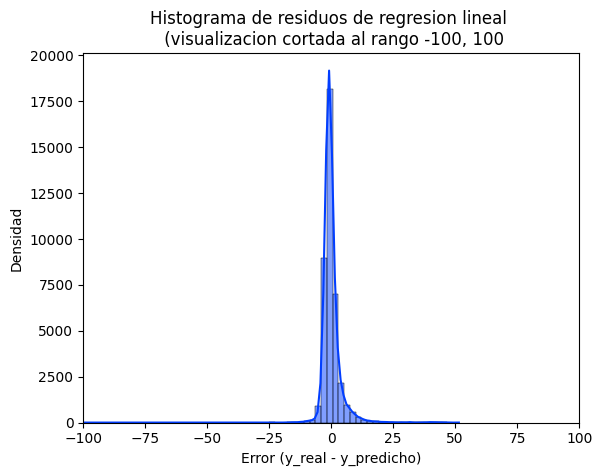

In [308]:
# Iniciamos el modelo
inicio = time.time()



lr = LinearRegression()

# Ajustamos
lr.fit(X_train_std, y_train)

# Predecimos
y_pred_test = lr.predict(X_test_std)
y_pred_train = lr.predict(X_train_std)

# Calcular metricas de error sobre Train
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

# Calcular metricas de error sobre Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)


fin = time.time()
tiempo = fin - inicio


# Representar errores en dataframe
metricas_error = {"MSE": {"Train": mse_train, "Test": mse_test},"RMSE": {"Train": rmse_train, "Test": rmse_test},"R²": {"Train": r2_train, "Test": r2_test},"MAPE": {"Train": mape_train, "Test": mape_test}}
df_metricas_error_lr = pd.DataFrame(metricas_error).T
print(df_metricas_error_lr)
print(f"Tiempo: {np.round(tiempo, 2)}")

# Graficamos
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Valores reales vs. predichos")
plt.show()


residuos_reg = (y_test - y_pred_test)
sns.histplot(residuos_reg, bins=100, alpha=0.5, kde=True)
plt.title("Histograma de residuos de regresion lineal \n (visualizacion cortada al rango -100, 100")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Densidad")
plt.xlim(-100,100)
plt.show()






#### Análisis gráficos regresión lineal
- Podemos observar en el primer gráfico que el modelo de regresión lineal tiende a subestimar valores altos de la variable y en cambio en los bajos están un poco dispersos con algunos registros más altos de lo normal.
- En el histograma de residuos vemos que los errores se concentran alrededor de cero pero que igualmente hay muchos valores que se alejan de cero.

### Gradiente descendiente

#### Definición de funciones y preparacion de datos

In [309]:
# definición de funciones de pérdida distintas y sus derivadas.
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(2/n) * (X.T @ (y_true - y_pred))

def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mae_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(1/n) * (X.T @ np.sign(y_true - y_pred))

def computar_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "R²": r2,"MAPE": mape}

In [310]:
def plot_loss(train_errors, val_errors):
    # gráfico de errores.
    plt.figure(figsize=(12, 4))
    plt.plot(train_errors, label='train_loss')
    plt.plot(val_errors, label='val_loss')
    plt.xlabel('Iteración')
    plt.ylabel('Loss')
    plt.title('Evolución de función de pérdida vs iteraciones')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_parameters(coef_history):
    # gráfico de coeficientes.
    coef_history = np.array(coef_history)
    plt.figure(figsize=(12, 4))
    for j in range(coef_history.shape[1]):
        plt.plot(coef_history[:, j], label=f'beta_{j}')
    plt.xlabel('Iteración')
    plt.ylabel('Valor del coeficiente')
    plt.title('Evolución de los coeficientes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [311]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient):
    """
    Gradient Descent para regresión lineal con tracking de errores y métricas.
    """

    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    # se guardan dimensiones
    n, m = X_train.shape
    o = X_val.shape[0]

    # se agrega columna de unos
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # inicialización de pesos
    W = np.random.randn(m+1, 1)

    # listas para trackeo
    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        # predicciones
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W

        # errores
        error_train = y_train - y_pred_train
        error_val = y_val - y_pred_val

        train_mse = np.mean(error_train ** 2)
        val_mse = np.mean(error_val ** 2)

        train_errors.append(train_mse)
        val_errors.append(val_mse)

        # gradiente
        gradient = grad_fn(X_train, y_train, y_pred_train)
        W -= lr * gradient

        # historial de coef
        coef_history.append(W.flatten())

    # gráficos
    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    # métricas finales
    y_pred_train_final = X_train @ W
    y_pred_val_final = X_val @ W

    



    train_metrics = computar_metricas(y_train, y_pred_train_final)
    val_metrics = computar_metricas(y_val, y_pred_val_final)

    residuos_grad = (y_val - y_pred_val_final).ravel()


    return W, train_metrics, val_metrics, residuos_grad

In [312]:
# Funcion gradiente descendiente estocastico
def stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient, batch_size=1):
    """
    Stochastic / Mini-batch Gradient Descent para regresión lineal
    con tracking de errores y métricas finales.
    """

    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    # agregamos columna de unos
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # inicialización de pesos
    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        # mezclar índices
        indices = np.random.permutation(n)

        # recorrer en batches
        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        # errores globales después de cada época
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())

    # gráficos
    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    # métricas finales
    y_pred_train_final = X_train @ W
    y_pred_val_final = X_val @ W

    train_metrics = computar_metricas(y_train, y_pred_train_final)
    val_metrics = computar_metricas(y_val, y_pred_val_final)
    residuos_grad_est = (y_val - y_pred_val_final).ravel()


    return W, train_metrics, val_metrics, residuos_grad_est

In [313]:
# Funcion gradiente descendiente mini batch
def mini_batch_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, batch_size=32, grad_fn=mse_gradient):
    """
    Mini-Batch Gradient Descent (MBGD) para regresión lineal con tracking de errores y coeficientes.
    """

    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    # agregamos columna de unos
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # inicialización de pesos
    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        indices = np.random.permutation(n)

        # batches
        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        # errores globales al final de la época
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())

    # gráficos
    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    # métricas finales
    y_pred_train_final = X_train @ W
    y_pred_val_final = X_val @ W

    train_metrics = computar_metricas(y_train, y_pred_train_final)
    val_metrics = computar_metricas(y_val, y_pred_val_final)
    residuos_grad_MB = (y_val - y_pred_val_final).ravel()


    return W, train_metrics, val_metrics, residuos_grad_MB

In [314]:
# Copiamos los conjuntos para trabajar luego con ellos
X_train_std_copia = X_train_std.copy()
y_train_copia = y_train.copy()
X_test_std_copia = X_test_std.copy()
y_test_copia = y_test.copy()

In [315]:
X_train_std.shape, y_train.shape, X_test_std.shape, y_test.shape

((159337, 37), (159337,), (39851, 37), (39851,))

In [316]:
# Hacer una tercera division del dataset para validacion
X_train_std, X_val, y_train, y_val = train_test_split(X_train_std, y_train, test_size=0.125, random_state=42)

In [317]:
# Convertimos a float y redimensionamos
X_train_std = np.asarray(X_train_std, dtype=float)
y_train = np.asarray(y_train, dtype=float).reshape(-1, 1)
X_test_std = np.asarray(X_test_std, dtype=float)
y_test = np.asarray(y_test, dtype=float).reshape(-1, 1)
X_val = np.asarray(X_val, dtype=float)
y_val = np.asarray(y_val, dtype=float).reshape(-1, 1)

#### Aplicacion de Gradiente descendiente

-Ajustamos hiper parámetros con el conjunto de validación.


-Probamos con un número mayor de épocas y con el gráfico determinamos que el error se mantenía estable en sus mínimos a partir de las 40 épocas aproximadamente.


-Después variamos subiendo la tasa de aprendizaje y vimos que el error disminuye más rápidamente pero a partir de un lr de 0.3 el algoritmo ya no convergía.


-En el gráfico de coeficientes vemos que estos se estabilizan sin demasiado ruido en 30 épocas aproximadamente.


-Observamos que en la prueba de test el error disminuye con respecto a la prueba con los datos de validación.



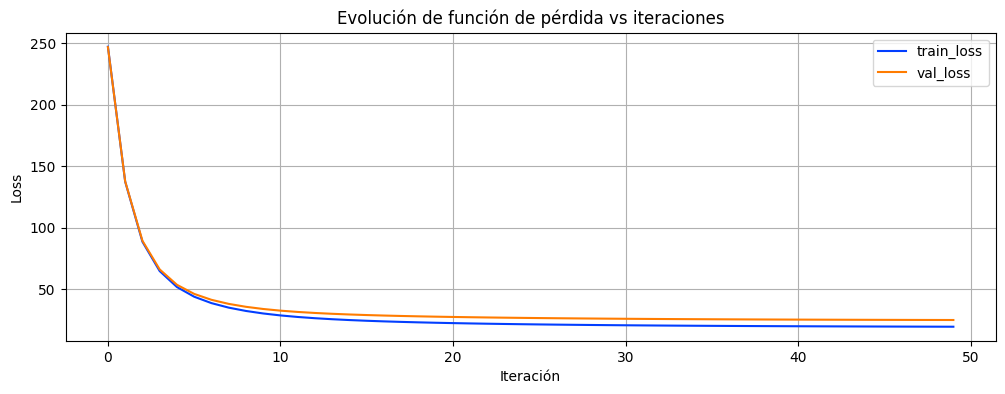

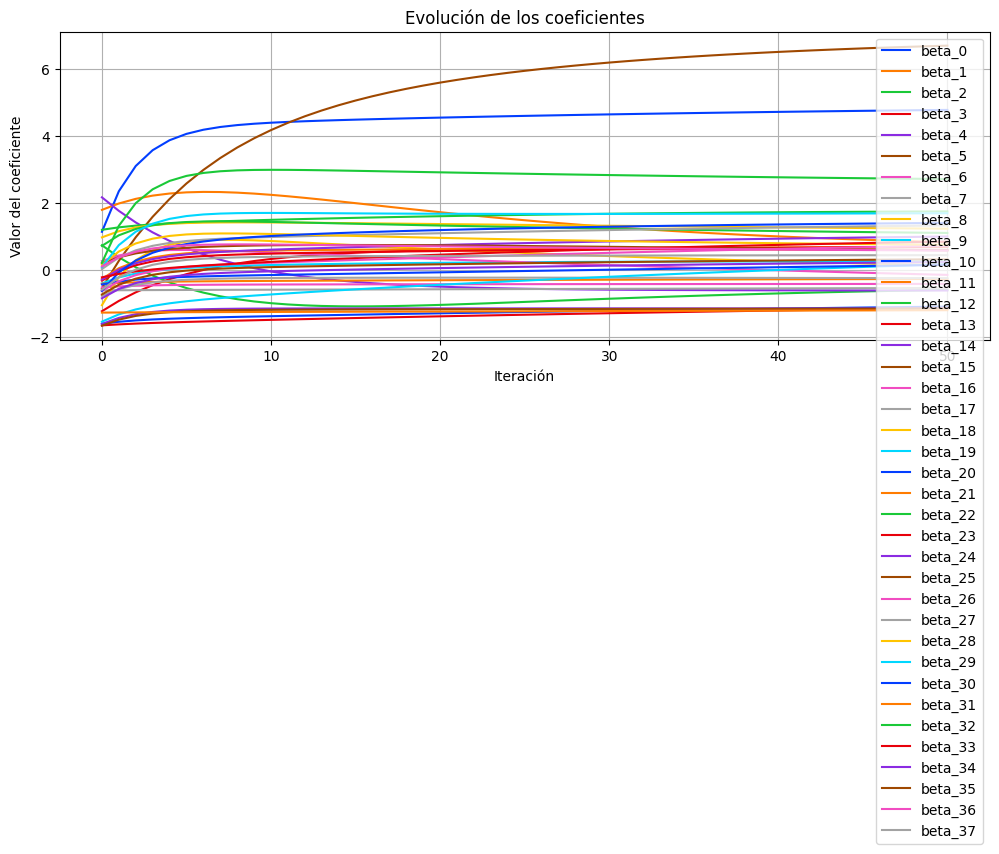

In [318]:
# Ejecutamos funcion gradiente con train y validacion
W, train_metrics, val_metrics, residuos_grad = gradient_descent(X_train_std, y_train, X_val, y_val, lr=0.05, epochs=50)

A continuación corremos el algoritmo usando los datos de test con los hiper parámetros fijados en la prueba anterior con el conjunto de validación.

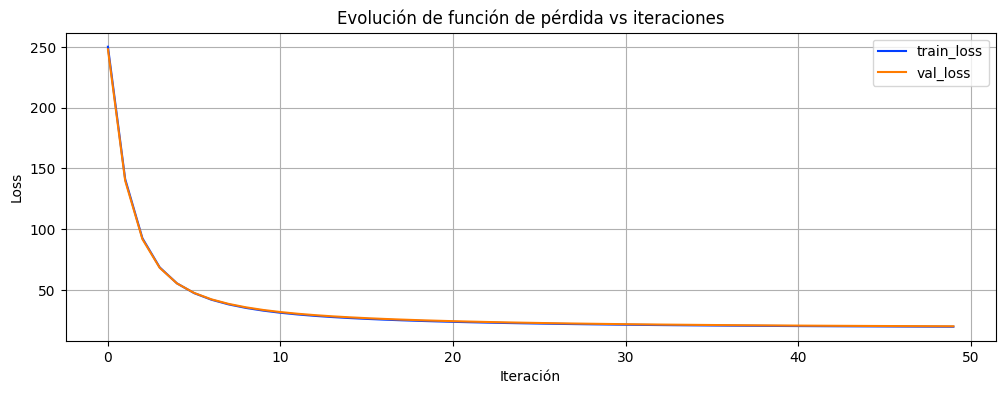

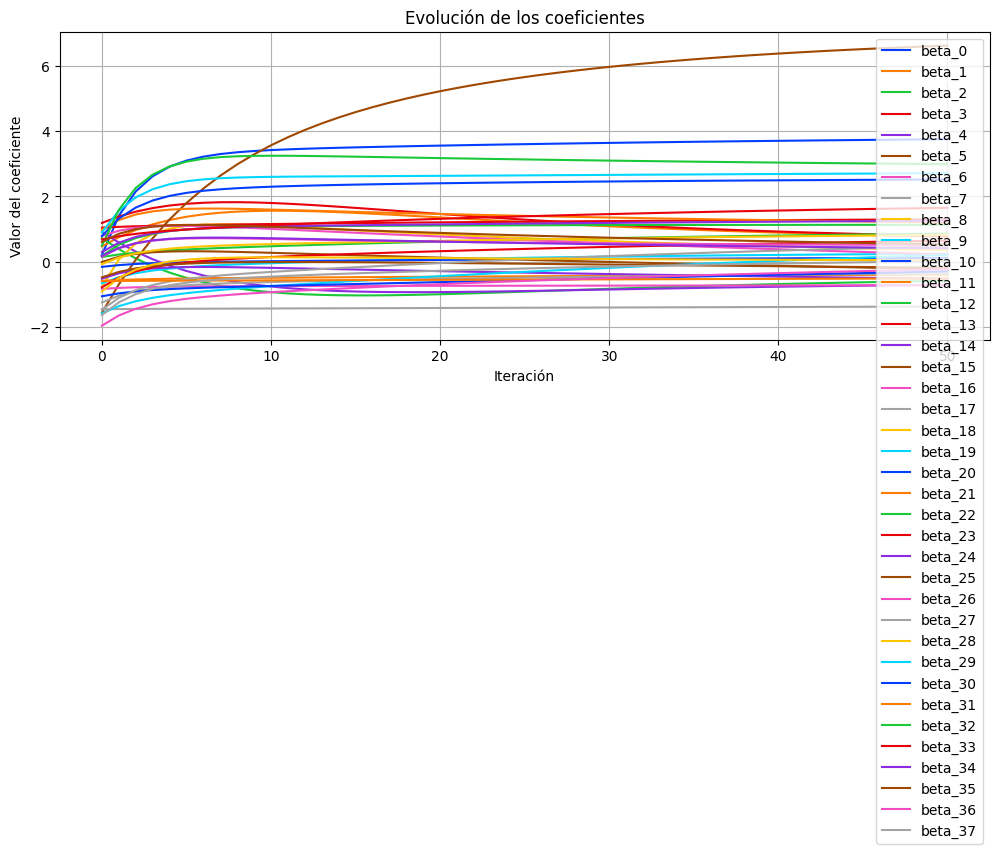

In [319]:
# Ejecutamos funcion gradiente con train y test
inicio = time.time()

W, train_metrics, val_metrics, residuos_grad = gradient_descent(X_train_std, y_train, X_test_std, y_test, lr=0.05, epochs=50)

fin = time.time()
tiempo = fin - inicio

In [320]:
df_metricas_error_gradiente = pd.DataFrame({"Train": train_metrics,"Test": val_metrics})
print(f"{df_metricas_error_gradiente} \nTiempo: {np.round(tiempo, 2)}")

          Train       Test
MSE   19.694142  20.055119
RMSE   4.437808   4.478294
R²     0.745679   0.737065
MAPE   0.253338   0.252173 
Tiempo: 0.81


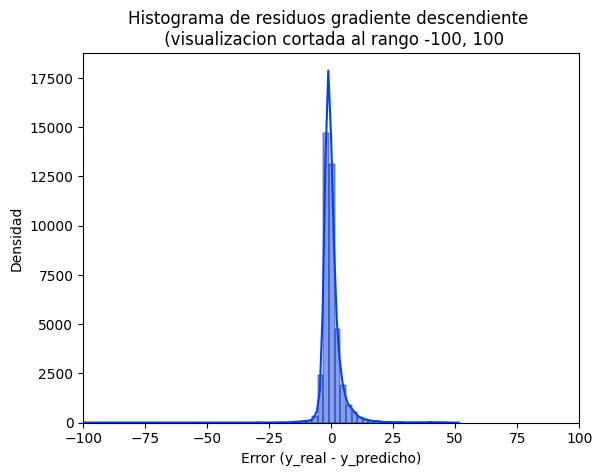

In [321]:
sns.histplot(residuos_grad, bins=100, alpha=0.5, kde=True)  
plt.title("Histograma de residuos gradiente descendiente \n (visualizacion cortada al rango -100, 100")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Densidad")
plt.xlim(-100,100)
plt.show()

#### Aplicacion de Gradiente descendiente estocástico

- Para el algoritmo de gradiente descendiente estocástico probamos varias épocas sin modificar el learning rate y descubrimos que el ruido que genera este algoritmo no nos permite encontrar los mejores hiperparametros porque cada pequeña variación de los mismos alteraba mucho los resultados obtenidos. Lo que podemos destacar a comparación de gradiente descendiente la función de pérdida arranca y se mantiene siempre más cerca de los mínimos (20 aproximadamente) y también que es mucho más lenta que el algoritmo anterior. Se observa también el ruido en el gráfico de los coeficientes.


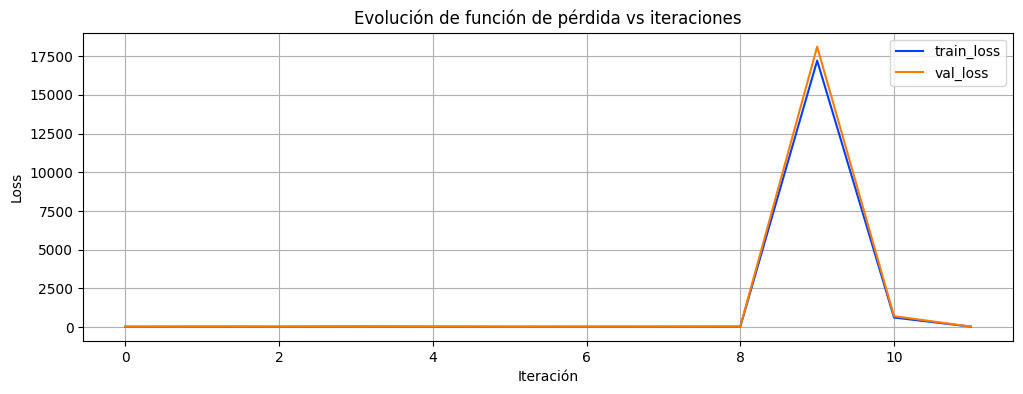

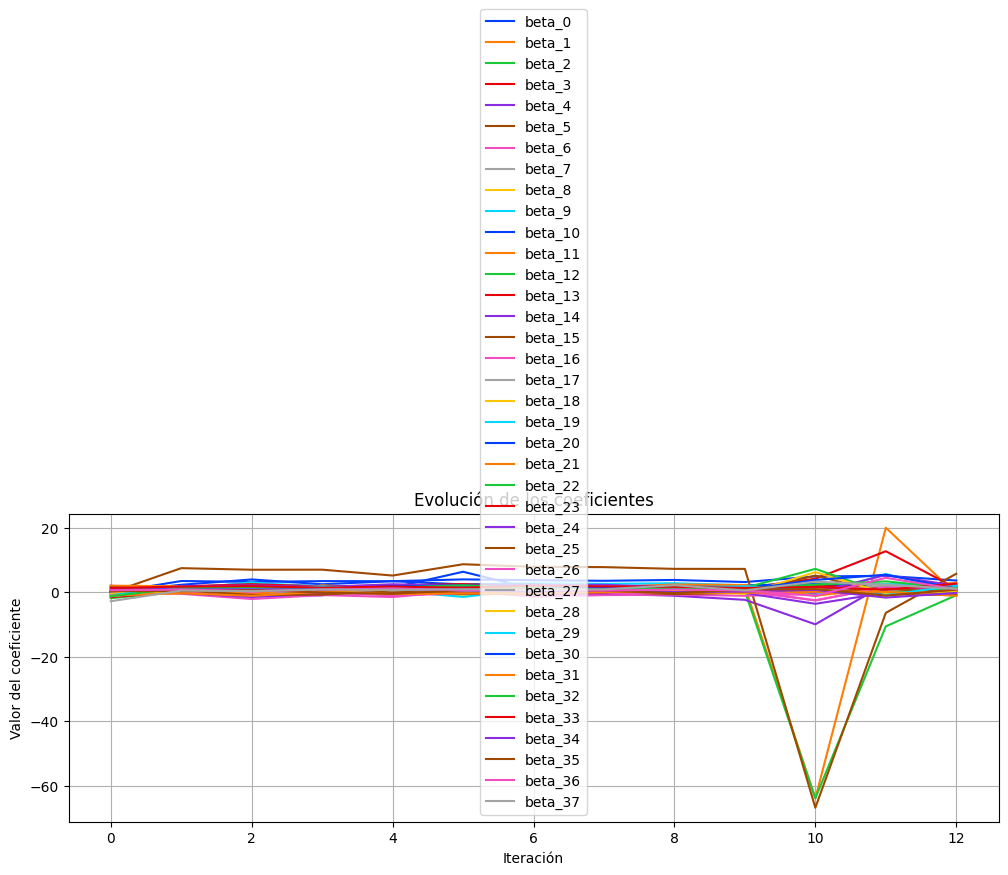

In [322]:
# Gradiente descendiente estocastico con train y validacion
W_est, train_metrics_est, val_metrics_est, residuos_grad_est = stochastic_gradient_descent(X_train_std, y_train, X_val, y_val, lr=0.01, epochs=12, batch_size=1)

A continuación corremos el algoritmo usando los datos de test con los hiper parámetros fijados en la prueba anterior con el conjunto de validación.

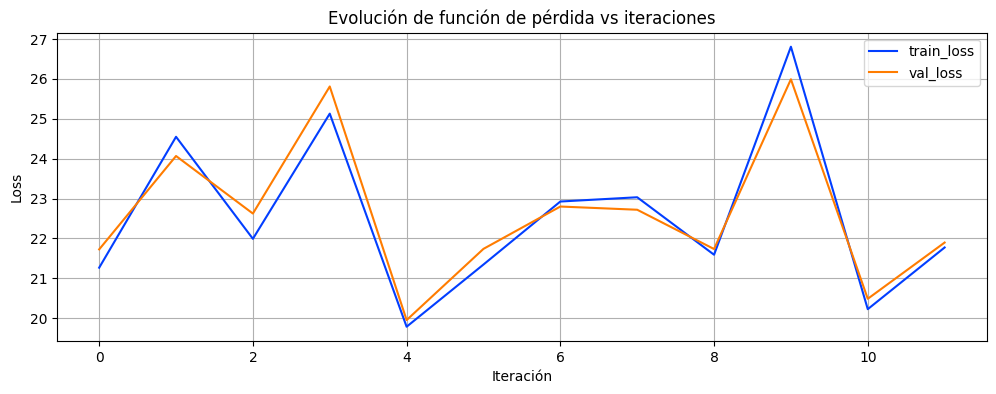

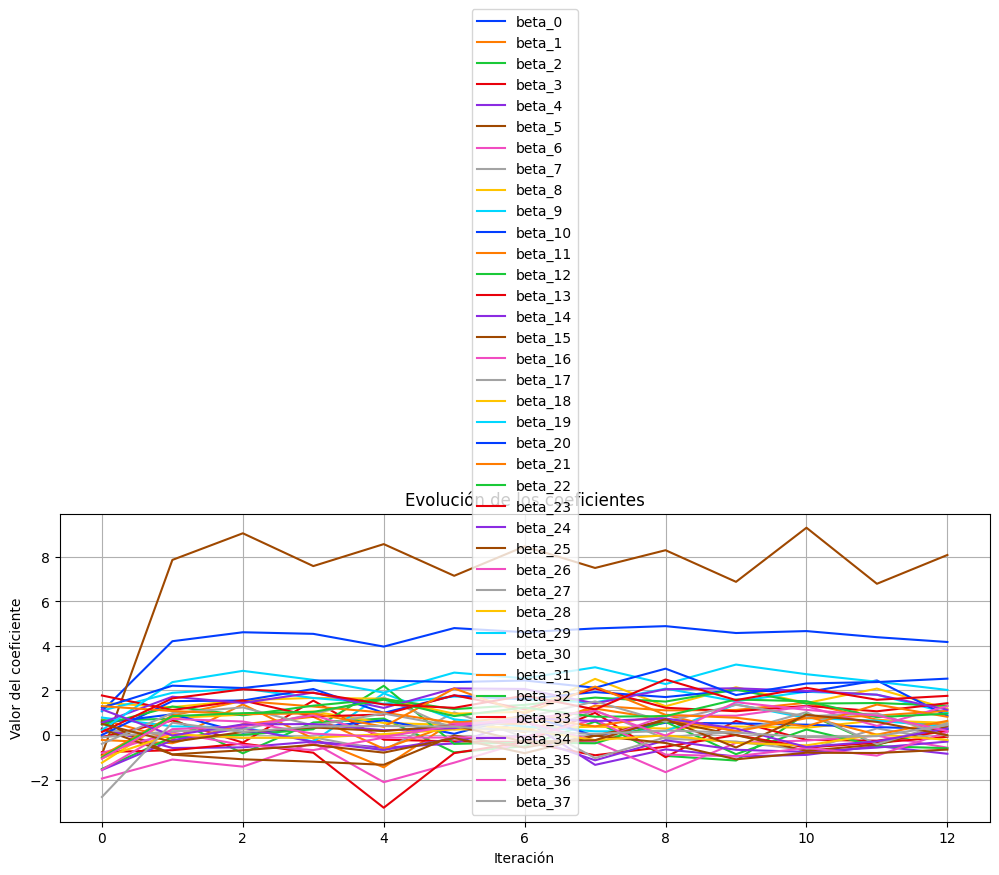

In [323]:
# Gradiente descendiente estocastico con train y test
inicio = time.time()

W_est, train_metrics_est, val_metrics_est, residuos_grad_est = stochastic_gradient_descent(X_train_std, y_train, X_test_std, y_test, lr=0.01, epochs=12, batch_size=1)

fin = time.time()
tiempo = fin - inicio

In [324]:
df_metricas_error_gradiente_est = pd.DataFrame({"Train": train_metrics_est,"Test": val_metrics_est})
print(f"{df_metricas_error_gradiente_est} \nTiempo: {np.round(tiempo, 2)}")

          Train       Test
MSE   21.774676  21.898376
RMSE   4.666334   4.679570
R²     0.718812   0.712898
MAPE   0.210997   0.211003 
Tiempo: 22.22


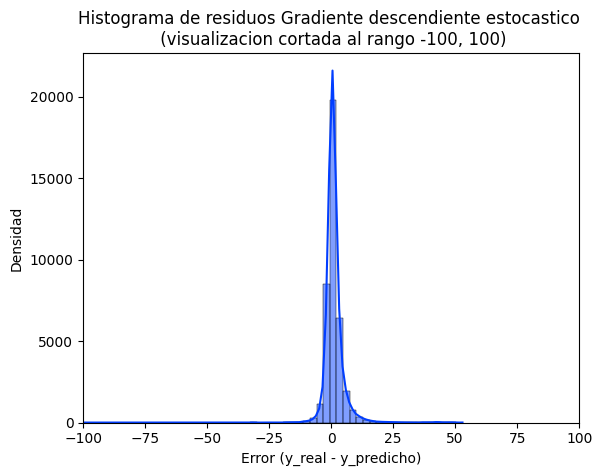

In [325]:
sns.histplot(residuos_grad_est, bins=100, alpha=0.5, kde=True)  
plt.title("Histograma de residuos Gradiente descendiente estocastico \n (visualizacion cortada al rango -100, 100)")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Densidad")
plt.xlim(-100,100)
plt.show()

#### Aplicación de Gradiente descendiente mini batch

In [326]:
# Calculamos el tamaño del batch como la raiz cuadrada de la cantidad de datos de nuestro conjunto de entrenamiento
batch = int(np.sqrt(len(X_train_std)))

- Probamos con configuraciones diferentes para gradiente descendiente mini batch y vimos que obtenemos resultados con menor ruido con un valor de learning rate bajo y una menor cantidad de épocas que gradiente descendiente ya que estamos trabajando con una menor cantidad de registros a la vez. También vemos que la función de pérdida comienza en valores bajos más similar en este sentido a gradiente descendiente estocástico y a su vez tardando una menor cantidad de tiempo considerable.
Los coeficientes se mantienen estables a partir de la décima iteración.

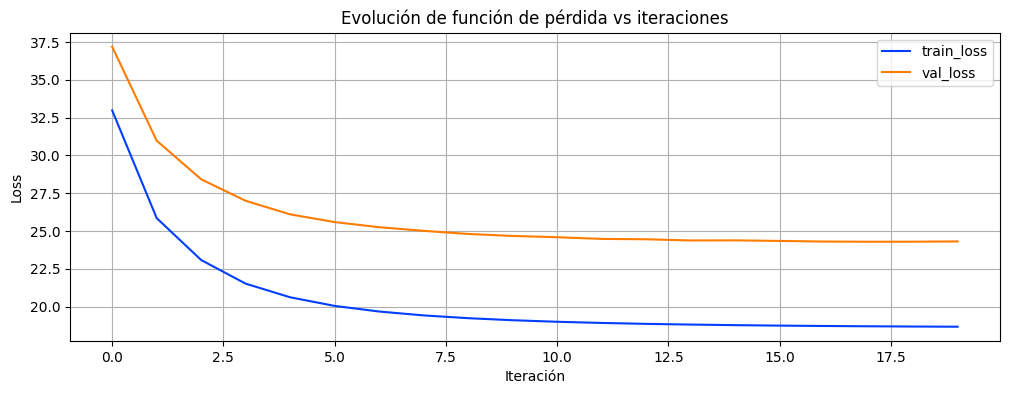

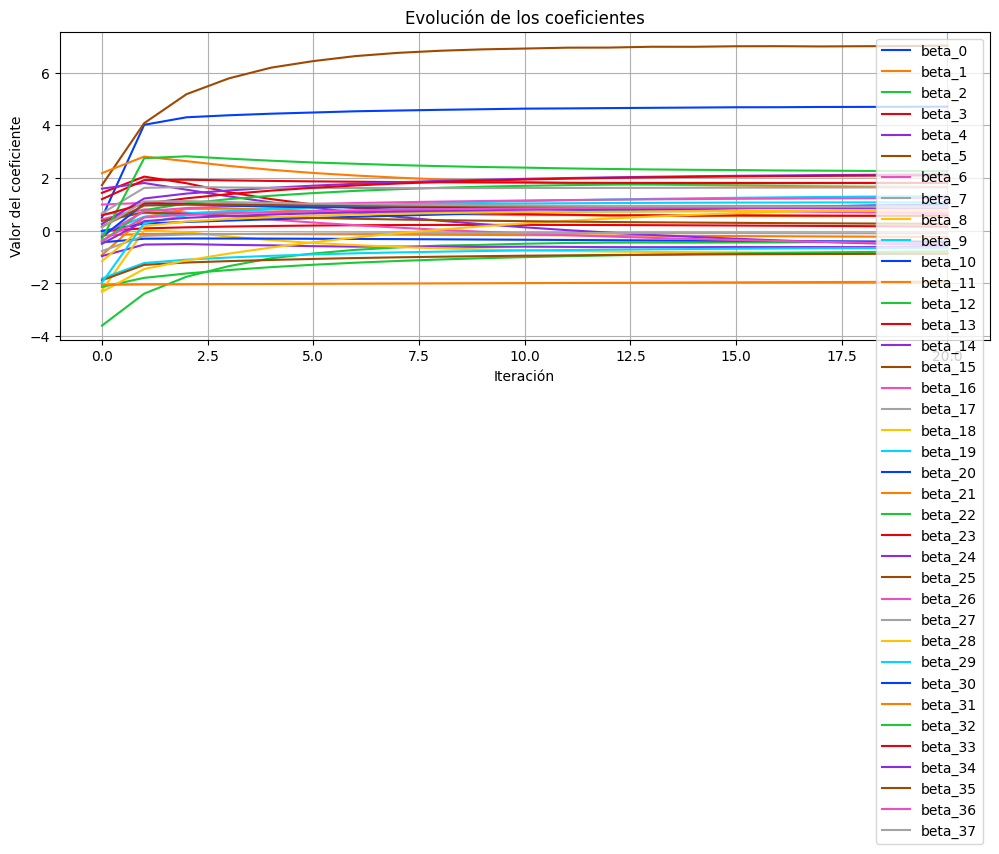

In [327]:
W_MB, train_metrics_MB, val_metrics_MB, residuos_grad_MB = mini_batch_gradient_descent(X_train_std, y_train, X_val, y_val, lr=0.001, batch_size=batch, epochs=20, grad_fn = mse_gradient)

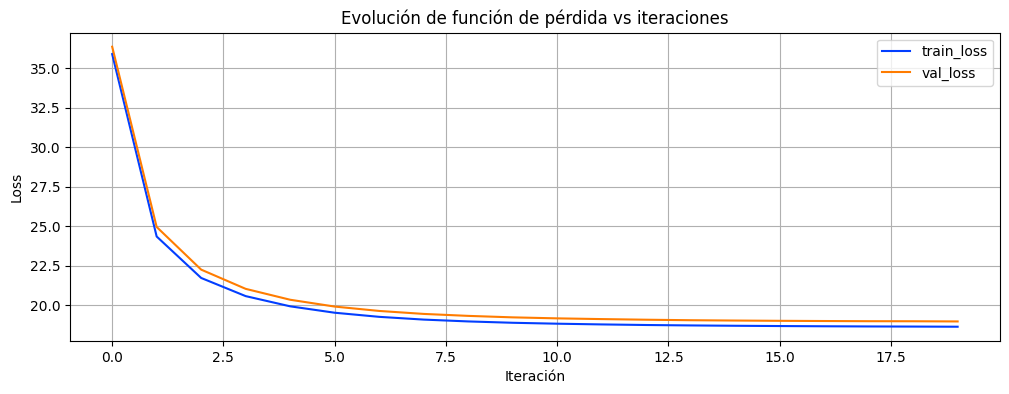

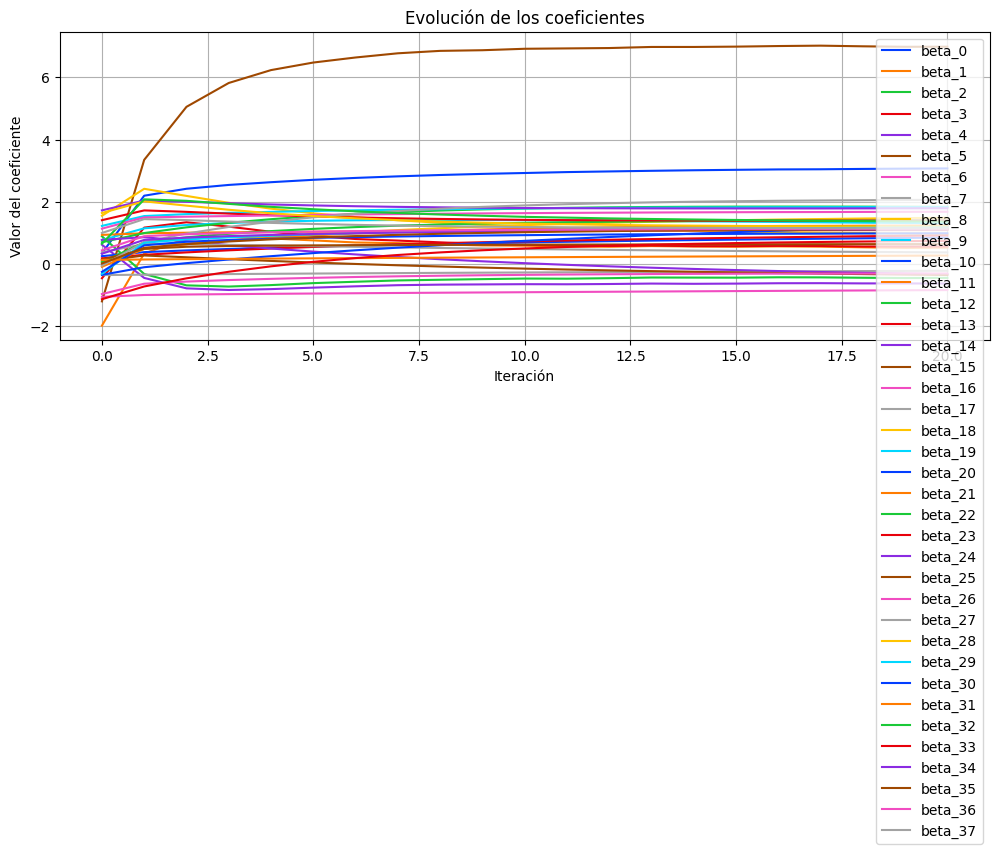

In [328]:
# Gradiente descendiente minibatch con train y test
inicio = time.time()

W_MB, train_metrics_MB, val_metrics_MB, residuos_grad_MB = mini_batch_gradient_descent(X_train_std, y_train, X_test_std, y_test, lr=0.001, batch_size=batch, epochs=20, grad_fn=mse_gradient)

fin =time.time()
tiempo = fin - inicio

In [329]:
df_metricas_error_gradiente_MB = pd.DataFrame({"Train": train_metrics_MB,"Test": val_metrics_MB})
print(f"{df_metricas_error_gradiente_MB} \nTiempo: {np.round(tiempo, 2)}")

          Train       Test
MSE   18.631266  18.965623
RMSE   4.316395   4.354954
R²     0.759404   0.751349
MAPE   0.232084   0.231532 
Tiempo: 2.02


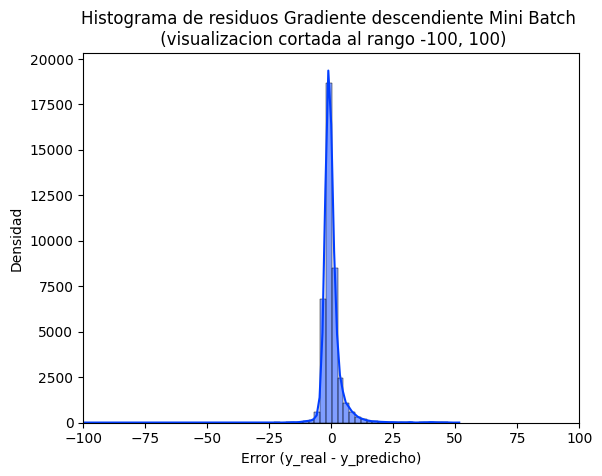

In [330]:
sns.histplot(residuos_grad_MB, bins=100, alpha=0.5, kde=True)  
plt.title("Histograma de residuos Gradiente descendiente Mini Batch \n (visualizacion cortada al rango -100, 100)")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Densidad")
plt.xlim(-100,100)
plt.show()

### Metodos de Regularización

In [331]:
# Volver a recuperar los dataset que antes convertimos a array
X_train_std = X_train_std_copia
y_train = y_train_copia
X_test_std = X_test_std_copia
y_test = y_test_copia

#### Lasso

Mejor valor de alpha encontrado: 0.00025529080682395165
          Train       Test
MSE   19.236194  18.888336
RMSE   4.385909   4.346071
R²     0.751885   0.752362
MAPE   0.234284   0.232634
Tiempo: 27.36


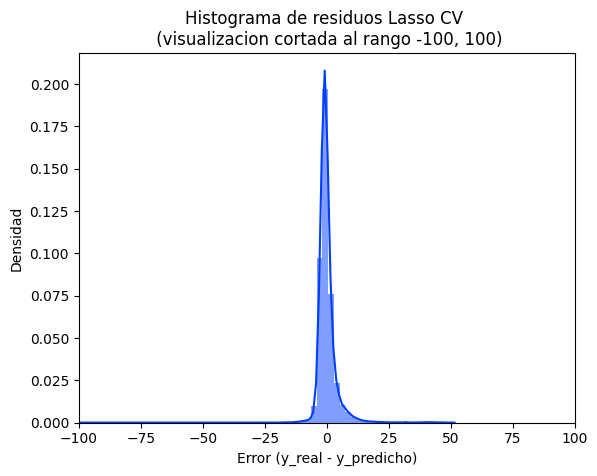

In [332]:
# Instanciamos el regularizador 
inicio = time.time()


lassoCV = LassoCV(alphas = np.logspace(-5, 15, 200), cv=10, max_iter=10000)

# Entrenamos
lassoCV.fit(X_train_std,y_train)


# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {lassoCV.alpha_}")

# Predicciones
y_pred_test = lassoCV.predict(X_test_std)
y_pred_train = lassoCV.predict(X_train_std)

# Calcular metricas de error sobre Train
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

# Calcular metricas de error sobre Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

fin = time.time()
tiempo = fin - inicio

# Metricas
metricas_error = {"MSE": {"Train": mse_train, "Test": mse_test},"RMSE": {"Train": rmse_train, "Test": rmse_test},"R²": {"Train": r2_train, "Test": r2_test},"MAPE": {"Train": mape_train, "Test": mape_test}}
df_metricas_error_lasso = pd.DataFrame(metricas_error).T
print(df_metricas_error_lasso)
print(f"Tiempo: {np.round(tiempo, 2)}")




sns.histplot((y_test - y_pred_test), alpha=0.5, kde=True, stat="density", linewidth=0,bins=100)
plt.title("Histograma de residuos Lasso CV \n (visualizacion cortada al rango -100, 100)")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Densidad")
plt.xlim(-100,100)
plt.show()

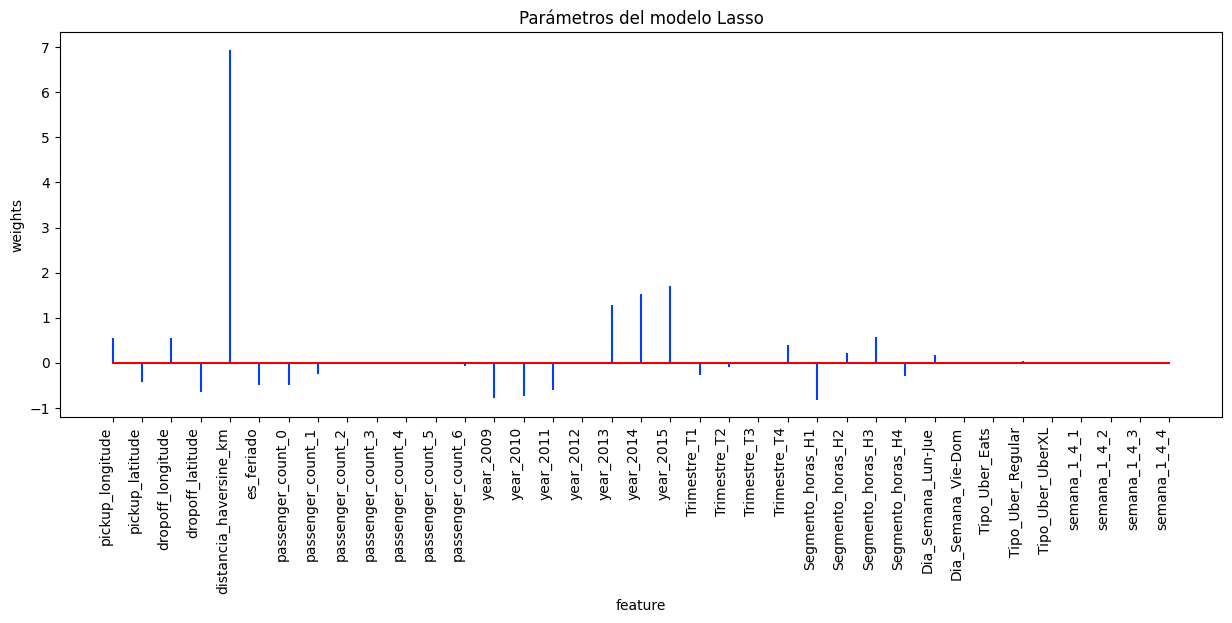

In [333]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_train_std.columns,'coef': lassoCV.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo Lasso')
plt.show()

#### Ridge

Mejor valor de alpha encontrado: 217.11179456945052
          Train       Test
MSE   19.236448  18.891148
RMSE   4.385937   4.346395
R²     0.751882   0.752325
MAPE   0.234535   0.232883
Tiempo: 8.49


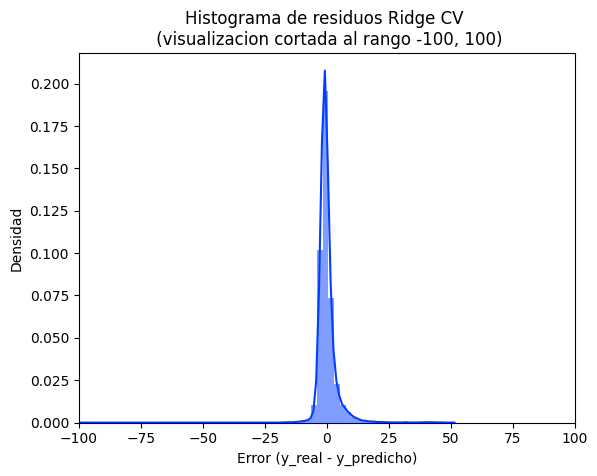

In [334]:
# Instanciamos regularizador 
inicio = time.time()

ridgeCV = RidgeCV(alphas = np.logspace(-5, 15, 200), fit_intercept = True, store_cv_results = True)

# Ajustamos
ridgeCV.fit(X_train_std,y_train)


# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {ridgeCV.alpha_}")

# Predecimos
y_pred_test = ridgeCV.predict(X_test_std)
y_pred_train = ridgeCV.predict(X_train_std)

# Calcular metricas de error sobre Train
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

# Calcular metricas de error sobre Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)


fin = time.time()
tiempo = fin - inicio

# Metricas
metricas_error = {"MSE": {"Train": mse_train, "Test": mse_test},"RMSE": {"Train": rmse_train, "Test": rmse_test},"R²": {"Train": r2_train, "Test": r2_test},"MAPE": {"Train": mape_train, "Test": mape_test}}
df_metricas_error_ridge = pd.DataFrame(metricas_error).T
print(df_metricas_error_ridge)
print(f"Tiempo: {np.round(tiempo, 2)}")

sns.histplot((y_test - y_pred_test), alpha=0.5, kde=True, stat="density", linewidth=0,bins=100)
plt.title("Histograma de residuos Ridge CV \n (visualizacion cortada al rango -100, 100)")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Densidad")
plt.xlim(-100,100)
plt.show()

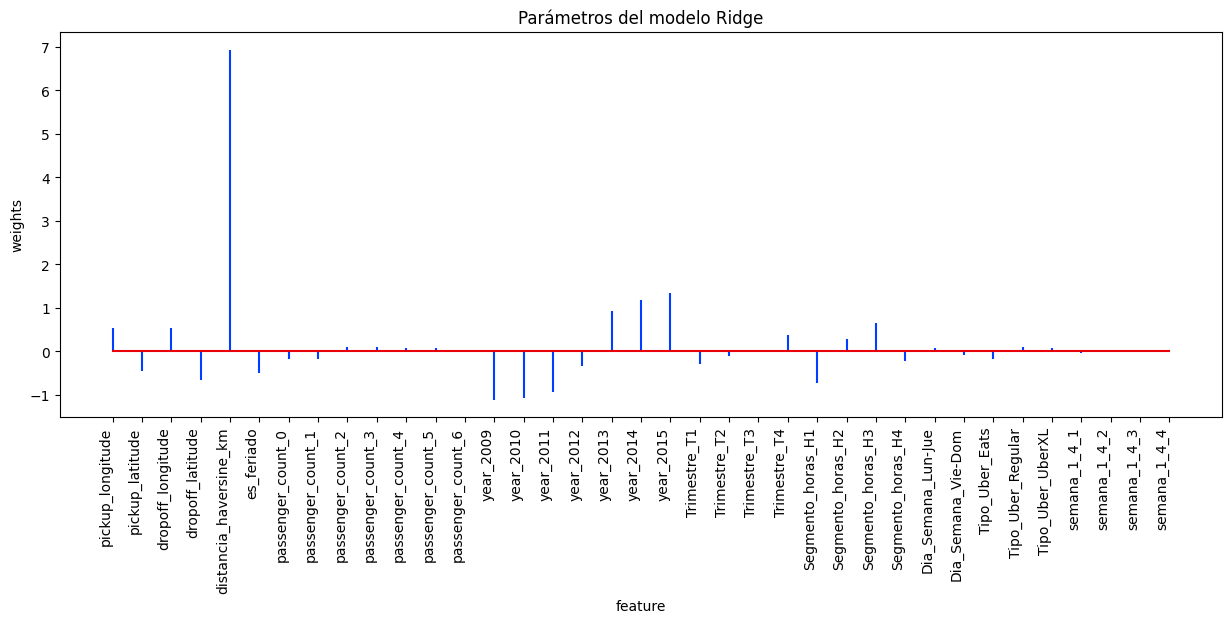

In [335]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_train_std.columns,'coef': ridgeCV.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo Ridge')
plt.show()

#### Elastic Net

Mejor valor de alpha : 0.0010234114021054539
Mejor valor de l1_ratio encontrado: 0.001
          Train       Test
MSE   19.236323  18.890326
RMSE   4.385923   4.346300
R²     0.751883   0.752336
MAPE   0.234479   0.232827
Tiempo: 22.16


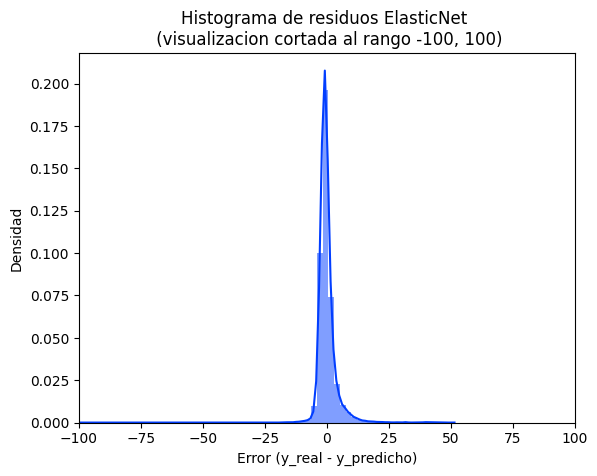

In [336]:
# Instanciamos el regularizador
inicio = time.time()


elasticnet = ElasticNetCV(l1_ratio = [0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],alphas = np.logspace(-5, 15, 200), cv = 10, max_iter=10000)

# Entrenamos
elasticnet.fit(X_train_std,y_train)


# Mejor valor alpha encontrado
print(f"Mejor valor de alpha : {elasticnet.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {elasticnet.l1_ratio_}")

# Predecimos
y_pred_test = elasticnet.predict(X_test_std)
y_pred_train = elasticnet.predict(X_train_std)

# Calcular metricas de error sobre Train
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

# Calcular metricas de error sobre Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)



fin = time.time()
tiempo = fin - inicio

# Metricas
metricas_error = {"MSE": {"Train": mse_train, "Test": mse_test},"RMSE": {"Train": rmse_train, "Test": rmse_test},"R²": {"Train": r2_train, "Test": r2_test},"MAPE": {"Train": mape_train, "Test": mape_test}}
df_metricas_error_EN = pd.DataFrame(metricas_error).T
print(df_metricas_error_EN)
print(f"Tiempo: {np.round(tiempo, 2)}")


sns.histplot((y_test - y_pred_test), alpha=0.5, kde=True, stat="density", linewidth=0,bins=100)
plt.title("Histograma de residuos ElasticNet \n (visualizacion cortada al rango -100, 100)")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Densidad")
plt.xlim(-100,100)
plt.show()

En los métodos de regularización optamos por usar las versiones de estos algoritmos que utilizan cross validation para que el algoritmo pueda encontrar el valor de $\lambda$ que mejor controla la fuerza de la regularización. Pusimos como hiper parámetro que el valor $\lambda$ varíe entre doscientos números espaciados logarítmicamente entre $10^{-5}$ y $10^{15}$.
- Para LassoCV obtuvimos un valor de $\lambda$ = 0.0002
- Para Ridge CV obtuvimos un valor de $\lambda$ = 217.11


Para Elastic Net pusimos como hiper parámetro un l1_ ratio que varíe entre siete valores cercanos a cero y a uno para que el algoritmo encuentre la mejor relación entre los dos modelos anteriores.
- Obtuvimos un valor de $\lambda$ = 0.0010 y un l1_ ratio = 0.001. O sea que el mejor modelo entre Lasso y Ridge es Ridge.


### Comparacion de modelos

In [337]:
df_metricas_error_lr["Modelo"] = "LinearRegression"
df_metricas_error_gradiente["Modelo"]  = "Gradiente descendiente"
df_metricas_error_gradiente_est["Modelo"]  = "Gradiente descendiente estocastico"
df_metricas_error_gradiente_MB["Modelo"]  = "Gradiente descendiente Mini-Batch"
df_metricas_error_lasso["Modelo"]  = "Lasso CV"
df_metricas_error_ridge["Modelo"]  = "Ridge CV"
df_metricas_error_EN["Modelo"]  = "ElasticNet CV"

df_comparacion = pd.concat([df_metricas_error_lr, df_metricas_error_gradiente, df_metricas_error_gradiente_est, df_metricas_error_gradiente_MB, df_metricas_error_lasso, df_metricas_error_ridge, df_metricas_error_EN], axis=0)

df_comparacion = df_comparacion.reset_index().set_index(["Modelo", "index"])

In [338]:
df_comparacion

Train       Test
Modelo                             index                      
LinearRegression                   MSE    19.236158  18.888021
                                   RMSE    4.385905   4.346035
                                   R²      0.751885   0.752366
                                   MAPE    0.234317   0.232665
Gradiente descendiente             MSE    19.694142  20.055119
                                   RMSE    4.437808   4.478294
                                   R²      0.745679   0.737065
                                   MAPE    0.253338   0.252173
Gradiente descendiente estocastico MSE    21.774676  21.898376
                                   RMSE    4.666334   4.679570
                                   R²      0.718812   0.712898
                                   MAPE    0.210997   0.211003
Gradiente descendiente Mini-Batch  MSE    18.631266  18.965623
                                   RMSE    4.316395   4.354954
                                   R²      0.759404   0.751349
                                   MAPE    0.232084   0.231532
Lasso CV                           MSE    19.236194  18.888336
                                   RMSE    4.385909   4.346071
                                   R²      0.751885   0.752362
                                   MAPE    0.234284   0.232634
Ridge CV                           MSE    19.236448  18.891148
                                   RMSE    4.385937   4.346395
                                   R²      0.751882   0.752325
                                   MAPE    0.234535   0.232883
ElasticNet CV                      MSE    19.236323  18.890326
                                   RMSE    4.385923   4.346300
                                   R²      0.751883   0.752336
                                   MAPE    0.234479   0.232827

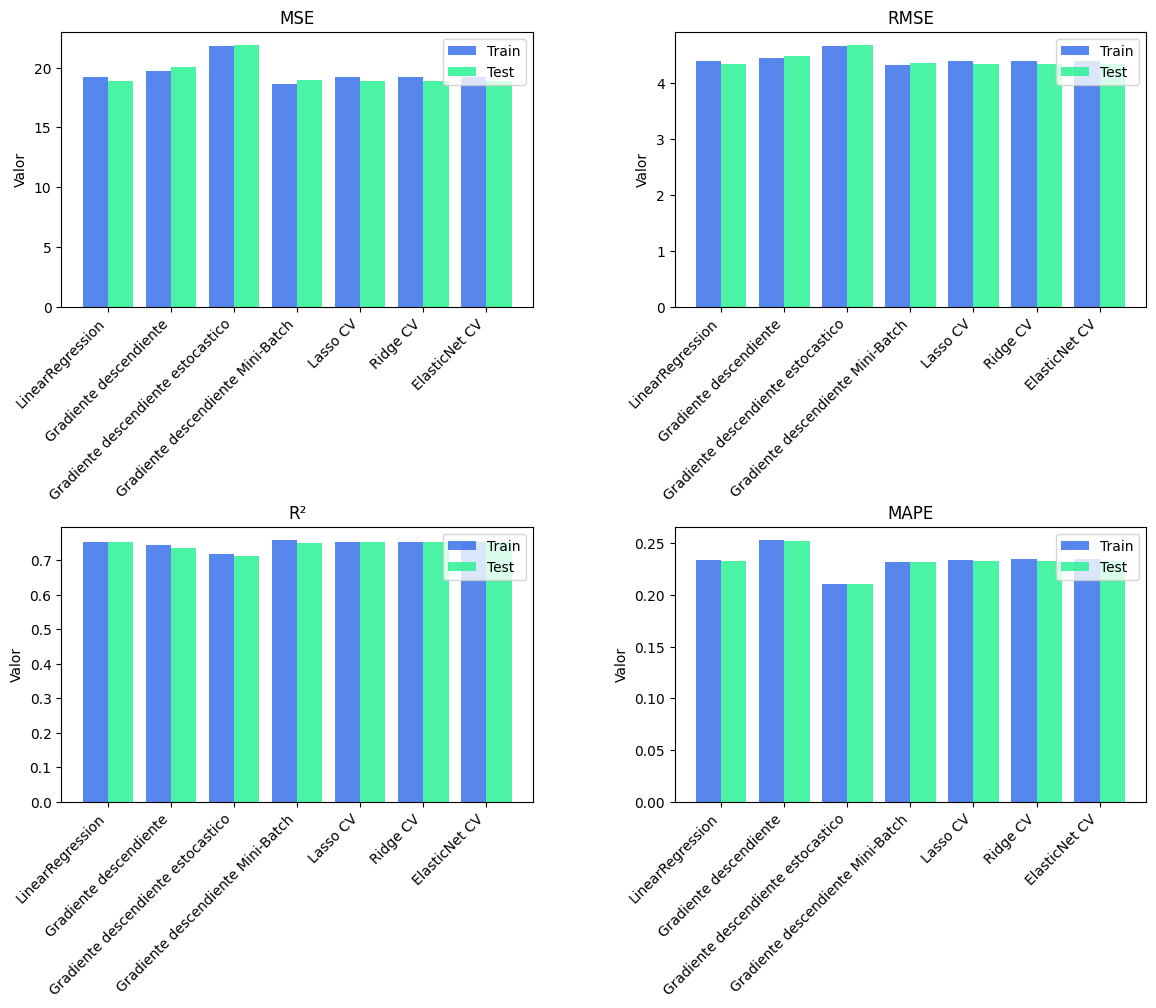

In [339]:

df_plot = df_comparacion.reset_index()

metricas = df_plot["index"].unique()
n_metricas = len(metricas)

color_train = "#2d68e9cc"
color_test  = "#28f194d5"

# Definir cantidad de columnas y filas dinámicamente
n_cols = 2
n_rows = (n_metricas + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
axes = axes.flatten()

for i, metrica in enumerate(metricas):
    ax = axes[i]
    subset = df_plot[df_plot["index"] == metrica]
    
    x = range(len(subset))
    ax.bar([p - 0.2 for p in x], subset["Train"], width=0.4, label="Train", color=color_train)
    ax.bar([p + 0.2 for p in x], subset["Test"], width=0.4, label="Test", color=color_test)
    
    ax.set_title(metrica)
    ax.set_xticks(x)
    ax.set_xticklabels(subset["Modelo"], rotation=45, ha='right')
    ax.set_ylabel("Valor")
    ax.legend()
    
# Ajustar espacio entre filas y columnas
fig.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()

#### ¿Cuál es mejor?
Al realizar el gráfico que compara todas las métricas usadas (R2,MSE,RMSE,MAPE) podemos tomar primeramente una determinación de cuál es el modelo que peor resultados nos dio, gradiente descendiente estocástico, ya que presenta las peores métricas en MSE y consecuentemente en RSME, además presenta el mayor error en R2 lo cual sugiere que no fue la estrategia más adecuada para este conjunto de datos en las condiciones probadas, además en nuestro caso particular al ejecutar el algoritmo fue el que más tiempo nos llevó su ejecución.


Por otra parte si tenemos que elegir un ganador en la selección del modelo podemos decir que RidgeCV junto a ElasticNetCV,con un valor que tiende a 0 en L1_ratio (lo que por definición hace que actúe como el primero), son los ganadores, ya que presentan una consistencia entre los conjuntos de test y train, lo que indica una buena capacidad de generalizar con valores no vistos, además presenta un buen desempeño en R2 que nos da una gran capacidad explicativa de la varianza. También podríamos hacer una mención especial al algoritmo de regresión lineal por su similitud a las métricas de los anteriores pero que actúa de una manera más sencilla y mucho más rápido.


En resumen podemos concluir que, a excepción del gradiente descendiente estocástico, no existe una gran diferencia entre los modelos utilizados, por lo que la elección de un modelo por sobre otro deba ser trabajo de probar según el contexto o la aplicación en la que estamos utilizando dichos algoritmos.





## Conclusiones del trabajo
A modo de cierre de este trabajo práctico podemos decir que según los modelos implementados, las principales variables que explican el valor de la objetivo, en este caso el precio de las tarifas, son en primer lugar la distancia, lo cual es lógico ya que demandará una mayor cantidad de todos los recursos para realizar el viaje (mayor tiempo del conductor con un trayecto, mas gasto en combustible, etc.) Seguido a ella observamos que tienen peso los años en los cuales se realizaron los viajes, esto podría deberse a eventos inflacionarios en Estados Unidos o a otros procesos que se nos escapan al alcance de este proyecto, y en menor medida también influyen las horas en las que se realizaron los viajes, las coordenadas de inicio y final (relacionadas con la distancia) y si ese dia fue feriado.


Los modelos en su gran mayoría como detallamos previamente tuvieron una buena actuación, logrando una capacidad de generalización y de explicatividad de la varianza buena, quizás se podría mejorar teniendo una menor cantidad de registros a imputar, rellenar o eliminar, lo que favorece que todas las variables están actuando sin sesgo ni error.


Creemos que la elección de las variables y sus posteriores agrupaciones o transformaciones son las correctas pero con algunas nos llevamos sorpresas, porque quizás para los modelos lineales dichas características no tienen la influencia que nosotros prevemos, como por ejemplo el tipo de uber, los cuales los métodos de regularización le asignaron una influencia muy baja, o las semanas del mes que a priori pensamos que por una cuestión del sueldo de las personas a final de mes podrían variar en su precio.
